Pontificia Universidad Católica de Chile <br>
Departamento de Ciencia de la Computación <br>
IIC3641 - Aprendizaje Automático Basado en Grafos <br>
Segundo Semestre 2025<br>


<h1><center> Tarea 3  </center></h1>
        Profesor: Marcelo Mendoza<br>
        Fecha de entrega: 22 de octubre


---

## Indicaciones

Se debe entregar **SOLO** el archivo .ipynb en el buzón respectivo en canvas.

**IMPORTANTE**:
- Se asignará puntaje por el código implementado y los comentarios asociados a resultados.
- El notebook debe tener todas las celdas de código ejecutadas.
- Cualquier instancia de copia resultará en un 1.1 como nota de curso.

---

# Integrantes del grupo

* Estudiante 1: Juan Hernandez
* Estudiante 2: Ignacio Vergara
* Estudiante 3: Diego Larraguibel

# Librerías

In [1]:
import dgl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import networkx as nx
import torch
import random
import torch.nn.functional as F
from functools import partial

seed = 1001
device = "cpu"

# Parte 1: Relational Graph Convolutional Network (R-GCN) (20 puntos)

En esta primera sección se trabaja con el dataset BGSDataset, disponible en dgl.

Ver enlace: https://www.dgl.ai/dgl_docs/generated/dgl.data.BGSDataset.html#dgl.data.BGSDataset

**Observación**

Para trabajar con el código visto en clases deben ajustar la versión de pytorch.

## 1.1 Conceptos básicos (5 puntos)


Responda las siguientes preguntas:

1. Mencione y describa los elementos que diferencian las arquitecturas **GCN** y **R-GCN**.

2. Explique las principales diferencias en el proceso de entrenamiento de arquitecturas basadas en **R-GCN**, considerando las tareas **Clasificación de nodos** y **Predicción de enlaces**

1. Las R-GCN generalizan las GCN, cuya arquitectura solo permite una relación por par de nodos, a múltiples relaciones. A nivel de implementación GCN aplica una convolución que combina las características de los vecinos de cada nodo mediante una matriz de adyacencia. En cambio, la R-GCN, al trabajar en grafos multirrelacionales considera un conjunto de matrices de peso específicas por tipo de relación y combina sus efectos mediante una suma ponderada.

2. En el proceso de entrenamiento, las R-GCN pueden aplicarse a distintas tareas, principalmente clasificación de nodos y predicción de enlaces, y cada una requiere un enfoque diferente. En la clasificación de nodos, el modelo aprende a predecir la etiqueta o categoría de un tipo específico de nodo, usando como entrada la información de sus vecinos y de las relaciones que lo conectan con ellos. Este entrenamiento se realiza con una función de pérdida de entropía cruzada y un conjunto de nodos etiquetados, de manera similar a una GCN tradicional. En cambio, en la predicción de enlaces, el modelo busca estimar si debería existir una conexión entre dos nodos del grafo. Para ello, primero genera representaciones (embeddings) de los nodos y luego utiliza un decodificador que combina los embeddings de los pares de nodos candidatos.

**Fuente:**  
Clases, [Tutorial de DGL](https://www.dgl.ai/dgl_docs/en/2.3.x/tutorials/models/1_gnn/4_rgcn.html)


## 1.2 Análisis descriptivo (5 puntos)

Grafique el grafo y calcule medidas descriptivas para caracterizarlo. Comente sus resultados.

**Observación**

En caso de no poder graficar la red completa, se recomienda trabajar con un subconjunto de 15.000 nodos (demora cerca de 12 minutos). Esto **SOLO** aplica para este punto. **La actividad 1.3 debe considerar todo el grafo.**

Respuesta:

In [2]:
ds = dgl.data.BGSDataset()
g_hetero = ds[0]
category = ds.predict_category
category_id = g_hetero.get_ntype_id(category)
num_rels = len(g_hetero.etypes)
num_classes = ds.num_classes

train_mask = g_hetero.nodes[category].data['train_mask']
test_mask = g_hetero.nodes[category].data['test_mask']
label = g_hetero.nodes[category].data['label']

Done loading data from cached files.


In [ ]:
G = dgl.to_networkx(g_hetero)
G_undirected = G.to_undirected()

In [23]:
G.number_of_nodes()

94806

In [21]:
sample = random.sample(list(G.nodes()), k=min(15000, G.number_of_nodes()))
H = G_undirected.subgraph(sample)
pos_C = nx.spring_layout(H, seed=seed, iterations=50, weight=None, threshold=1e-4)

Text(0.5, 1.0, 'Grafo de BGS (subgrafo de 5000 nodos)')

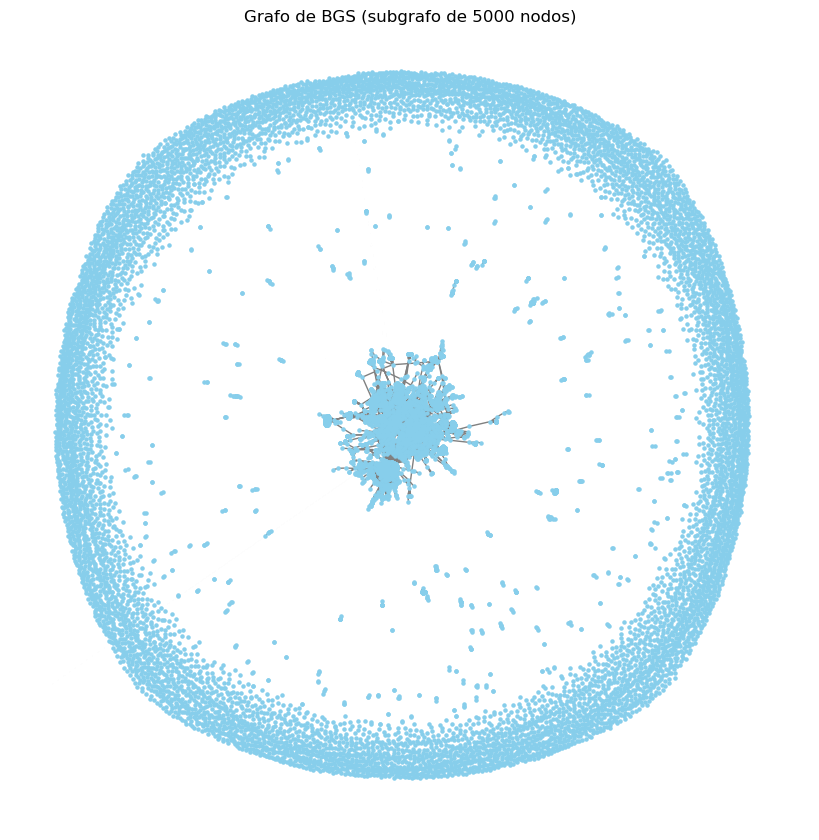

In [22]:
plt.figure(figsize=(8, 8))
nx.draw(H, pos_C, node_size=5, node_color='skyblue', edge_color='gray', with_labels=False,)
plt.title('Grafo de BGS (subgrafo de 15.000 nodos)')

In [26]:
def funcion_descriptora(G, nombre):
    # Printeo de las características solicitadas
    df_datos = pd.DataFrame([{"Nodos": None, "Aristas": None, "Componentes": None, "Grado Promedio": None, "Diámetro": None, "Camino mínimo promedio": None}])
    df_datos["Nodos"] = len(G.nodes())
    df_datos["Aristas"] = len(G.edges())
    df_datos["Componentes"] = nx.number_connected_components(G)
    degrees = np.array([G.degree(n) for n in G.nodes()])
    df_datos["Grado Promedio"] = np.mean(degrees)
    # En caso de que el grafo no sea conexo se debe determinar el diámetro analizando cada subgrafo del mismo
    if nx.is_connected(G):
        df_datos["Diámetro"] = nx.diameter(G)
    else:
        diam = 0
        for component in nx.connected_components(G):
            subgraph = G.subgraph(component)
            d = nx.diameter(subgraph)
            if diam <= d:
                diam = d
        df_datos["Diámetro"] = diam

    componentes = list(nx.connected_components(G))
    nodos_mayor_comp = max(componentes, key=len)
    mayor_comp = G.subgraph(nodos_mayor_comp)
    cmp_mayor_comp = nx.average_shortest_path_length(mayor_comp) # Camino mínimo promedio de la mayor componente
    df_datos["Camino mínimo promedio"] = cmp_mayor_comp

    print(f"Las estadísticas del grafo {nombre} son:")
    display(df_datos)

funcion_descriptora(H, "BGS")

Las estadísticas del grafo BGS son:


,Nodos,Aristas,Componentes,Grado Promedio,Diámetro,Camino mínimo promedio
0,15000,9097,8865,1.212933,21,6.225154


Se analizan los resultados para el subconjunto aleatorio de 15000 nodos delgrafo. Tanto del gráfico como de la tabla descriptiva podemos ver que hay un gran número de componentes (8865). Así mismo, el grafo presenta cadenas largas de nodos, con un diámetro de 21 y camino mínimo promedio 6.22.

## 1.3 Implementación R-GCN (10 puntos)

Entrene una arquitectura R-GCN para clasificar entidades. Defina el número de épocas de manera que se garantice la convergencia del entrenamiento y justifique su elección de hiperpámetros.

Grafique la función de pérdida y accuracy. Comente sus resultados.

Respuesta:

In [81]:
# Copiamos las clases para construir R-GCN desde la clase 10.

from functools import partial

import dgl
import dgl.function as fn
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph


class RGCNLayer(nn.Module):
    def __init__(
        self,
        in_feat,
        out_feat,
        num_rels,
        num_bases=-1, # esto indica que num_bases = num_rels
        bias=None,
        activation=None,
        is_input_layer=False,
    ):
        super(RGCNLayer, self).__init__()
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.num_rels = num_rels
        self.num_bases = num_bases # implementación eficiente de relaciones con combinación lineal de matrices base.
        self.bias = bias
        self.activation = activation
        self.is_input_layer = is_input_layer

        
        if self.num_bases <= 0 or self.num_bases > self.num_rels:
            self.num_bases = self.num_rels
        
        self.weight = nn.Parameter(
            torch.Tensor(self.num_bases, self.in_feat, self.out_feat)
        )
        if self.num_bases < self.num_rels:
            
            self.w_comp = nn.Parameter(
                torch.Tensor(self.num_rels, self.num_bases)
            )
        # add bias
        if self.bias:
            self.bias = nn.Parameter(torch.Tensor(out_feat))
        # init trainable parameters
        nn.init.xavier_uniform_(
            self.weight, gain=nn.init.calculate_gain("relu")
        )
        if self.num_bases < self.num_rels:
            nn.init.xavier_uniform_(
                self.w_comp, gain=nn.init.calculate_gain("relu")
            )
        if self.bias:
            nn.init.xavier_uniform_(
                self.bias, gain=nn.init.calculate_gain("relu")
            )

    def forward(self, g):
        if self.num_bases < self.num_rels:
            weight = self.weight.view(
                self.in_feat, self.num_bases, self.out_feat
            )
            weight = torch.matmul(self.w_comp, weight).view(
                self.num_rels, self.in_feat, self.out_feat
            )
        else:
            weight = self.weight
        if self.is_input_layer:

            def message_func(edges):
                embed = weight.view(-1, self.out_feat)
                index = edges.data[dgl.ETYPE] * self.in_feat + edges.src["id"]
                return {"msg": embed[index] * edges.data["norm"]}

        else:

            def message_func(edges):
                w = weight[edges.data[dgl.ETYPE]]
                msg = torch.bmm(edges.src["h"].unsqueeze(1), w).squeeze()
                msg = msg * edges.data["norm"]
                return {"msg": msg}

        def apply_func(nodes):
            h = nodes.data["h"]
            if self.bias:
                h = h + self.bias
            if self.activation:
                h = self.activation(h)
            return {"h": h}

        g.update_all(message_func, fn.sum(msg="msg", out="h"), apply_func)
        

class Model(nn.Module):
    def __init__(
        self,
        num_nodes,
        h_dim,
        out_dim,
        num_rels,
        num_bases=-1,
        num_hidden_layers=1,
    ):
        super(Model, self).__init__()
        self.num_nodes = num_nodes
        self.h_dim = h_dim
        self.out_dim = out_dim
        self.num_rels = num_rels
        self.num_bases = num_bases
        self.num_hidden_layers = num_hidden_layers

        # create rgcn layers
        self.build_model()

        # create initial features
        self.features = self.create_features()

    def build_model(self):
        self.layers = nn.ModuleList()
        # input to hidden
        i2h = self.build_input_layer()
        self.layers.append(i2h)
        # hidden to hidden
        for _ in range(self.num_hidden_layers):
            h2h = self.build_hidden_layer()
            self.layers.append(h2h)
        # hidden to output
        h2o = self.build_output_layer()
        self.layers.append(h2o)

    # initialize feature for each node
    def create_features(self):
        features = torch.arange(self.num_nodes)
        return features

    def build_input_layer(self):
        return RGCNLayer(
            self.num_nodes,
            self.h_dim,
            self.num_rels,
            self.num_bases,
            activation=F.relu,
            is_input_layer=True,
        )

    def build_hidden_layer(self):
        return RGCNLayer(
            self.h_dim,
            self.h_dim,
            self.num_rels,
            self.num_bases,
            activation=F.relu,
        )

    def build_output_layer(self):
        return RGCNLayer(
            self.h_dim,
            self.out_dim,
            self.num_rels,
            self.num_bases,
            activation=None,   # <-- antes: partial(F.softmax, dim=1)
        )


    def forward(self, g):
        if self.features is not None:
            g.ndata["id"] = self.features
        for layer in self.layers:
            layer(g)
        return g.ndata.pop("h")

In [94]:
g = dgl.to_homogeneous(g_hetero)
# justo después de crear el grafo homogéneo
E = g.num_edges()
dev = g.ndata[dgl.NTYPE].device
if 'norm' not in g.edata:
    g.edata['norm'] = torch.ones((E, 1), dtype=torch.float32, device=dev)
    
print(g)

Graph(num_nodes=94806, num_edges=672884,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64), 'norm': Scheme(shape=(1,), dtype=torch.float32)})


In [95]:
# 1) Asegura 'norm' en edges
if 'norm' not in g.edata:
    g.edata['norm'] = torch.ones(g.num_edges(), dtype=torch.float32, device=g.device if hasattr(g, "device") else None)

target_mask_global = (g.ndata[dgl.NTYPE] == category_id)
target_idx = torch.nonzero(target_mask_global, as_tuple=False).squeeze()
nid_target = g.ndata[dgl.NID][target_mask_global]

# 3) Reconstruye labels y máscaras en el homogéneo
labels_full = torch.full((g.num_nodes(),), -1, dtype=torch.long, device=nid_target.device)
labels_full[target_mask_global] = label[nid_target].long()

train_mask_full = torch.zeros(g.num_nodes(), dtype=torch.bool, device=nid_target.device)
train_mask_full[target_mask_global] = train_mask[nid_target].bool()

test_mask_full = torch.zeros(g.num_nodes(), dtype=torch.bool, device=nid_target.device)
test_mask_full[target_mask_global]  = test_mask[nid_target].bool()

train_idx = torch.nonzero(train_mask_full[target_idx], as_tuple=False).flatten()
test_idx  = torch.nonzero(test_mask_full[target_idx],  as_tuple=False).flatten()
labels_t  = labels_full[target_idx]

In [96]:
# configurations
n_hidden = 16  # number of hidden units
n_bases = -1  # use number of relations as number of bases
n_hidden_layers = 1  # use 1 input layer, 1 output layer, no hidden layer
n_epochs = 100  # epochs to train
lr = 0.01  # learning rate
l2norm = 0  # L2 norm coefficient

node_ids = torch.arange(g.num_nodes())
target_idx = node_ids[g.ndata[dgl.NTYPE] == category_id]

In [97]:
# Funcion para facilitar el entrenamiento y la validación

def train_model(
    n_epochs=50, lr=0.01, l2norm=0.0,
    patience=10, min_delta=1e-3, verbose=False, model=None
):
    if model is None:
        raise ValueError("Se debe proveer un modelo")

    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2norm)
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    best_val_loss = float('inf')
    best_epoch = -1
    best_state = None
    no_improve = 0

    for epoch in range(n_epochs):
        # ---------- TRAIN ----------
        model.train()
        opt.zero_grad()
        logits_all = model(g)                  # forward
        logits_trg = logits_all[target_idx]
        loss = F.cross_entropy(logits_trg[train_idx], labels_t[train_idx])
        loss.backward()
        opt.step()

        # ---------- EVAL ----------
        model.eval()
        with torch.no_grad():
            logits_all = model(g)
            logits_trg = logits_all[target_idx]

            # train metrics
            pred_tr = logits_trg[train_idx].argmax(1)
            y_tr = labels_t[train_idx]
            train_acc = (pred_tr == y_tr).float().mean().item()
            train_loss = F.cross_entropy(logits_trg[train_idx], y_tr).item()
            pred_va = logits_trg[test_idx].argmax(1)
            y_va = labels_t[test_idx]
            val_loss = F.cross_entropy(logits_trg[test_idx], y_va).item()
            val_acc  = (pred_va == y_va).float().mean().item()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        if verbose:
            print(f"Epoch {epoch:05d} | Train Acc: {train_acc:.4f} | "
                  f"Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f}")

        # ---------- EARLY STOP ----------
        improved = (best_val_loss - val_loss) > min_delta
        if improved or (best_epoch < 0 and val_loss < best_val_loss):
            best_val_loss = val_loss
            best_epoch = epoch
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                if verbose:
                    print(f"Early stopping en epoch {epoch} (mejor epoch: {best_epoch})")
                break

    history = {
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_acc": train_accs,
        "val_acc": val_accs,
    }
    best = {
        "epoch": best_epoch,
        "val_loss": best_val_loss,
        "val_acc": val_accs[best_epoch] if best_epoch >= 0 else None,
        "state_dict": best_state,
    }
    return history, best

In [98]:
# Testing with different hyperparams
from itertools import product

hidden_layers_options = [0, 1, 2]
hidden_dim_options = [8, 16, 32]
param_grid = [
    {"n_hidden_layers": nl, "n_hidden": nh}
    for nl, nh in product(hidden_layers_options, hidden_dim_options)
]

In [102]:
best_of_bests = None
best_val_acc = 0.0

for params in param_grid:
    print(f"Probando config: {params}")
    model = Model(
        g.num_nodes(),
        params["n_hidden"],
        num_classes,
        num_rels,
        num_bases=n_bases,
        num_hidden_layers=params["n_hidden_layers"],
    )

    history, best = train_model(model=model, n_epochs=n_epochs, patience=30)
    print(f"Best val_acc: {best['val_acc']:.4f} (epoch {best['epoch']})\n")
    if best["val_acc"] > best_val_acc:
        best_of_bests = {
            "model": model,
            "params": params,
            "history": history,
            "best": best,
        }
        best_val_acc = best["val_acc"]

Probando config: {'n_hidden_layers': 0, 'n_hidden': 8}
Best val_acc: 0.8621 (epoch 98)

Probando config: {'n_hidden_layers': 0, 'n_hidden': 16}
Best val_acc: 0.8276 (epoch 16)

Probando config: {'n_hidden_layers': 0, 'n_hidden': 32}
Best val_acc: 0.8276 (epoch 14)

Probando config: {'n_hidden_layers': 1, 'n_hidden': 8}
Best val_acc: 0.7241 (epoch 9)

Probando config: {'n_hidden_layers': 1, 'n_hidden': 16}
Best val_acc: 0.4483 (epoch 4)

Probando config: {'n_hidden_layers': 1, 'n_hidden': 32}
Best val_acc: 0.6552 (epoch 4)

Probando config: {'n_hidden_layers': 2, 'n_hidden': 8}
Best val_acc: 0.6897 (epoch 21)

Probando config: {'n_hidden_layers': 2, 'n_hidden': 16}
Best val_acc: 0.6207 (epoch 17)

Probando config: {'n_hidden_layers': 2, 'n_hidden': 32}
Best val_acc: 0.9310 (epoch 30)



En la parte de arriba se puede observar la validación de hiperparámetros realizada. Por un tema de cómputo, solo testeamos los hiperparámetros de ```cantidad de capas ocultas``` y ```cantidad de neuronas por capa oculta```. Se observa que varios modelos tienen la misma accuracy para el test de validación, y se elige entre ellos aquel que tiene la menor cantidad de parámetros. Finalmente, el campeón es ```{'n_hidden_layers': 2, 'n_hidden': 32}```, el cual obtuvo una accuracy de 0.93.

En cuanto al resto de los hiperparámetros, se mantuvieron constantes durante toda la búsqueda. Se utilizó una tasa de aprendizaje de 0.01, un número máximo de épocas (n_epochs) igual a 100. Además, se implementó un criterio de early stopping con una paciencia de 30 épocas y una mejora mínima de 1e-3, de modo que el entrenamiento se detuviera automáticamente si no se observaban mejoras relevantes en la pérdida de validación.


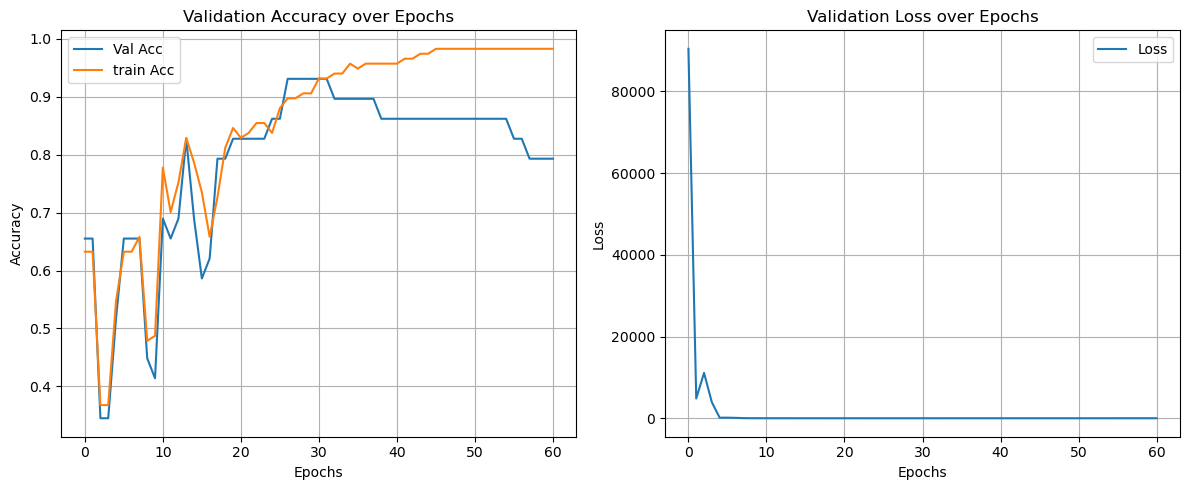

In [109]:
# Plots with a subplot the accs and loss

best_hist = best_of_bests["history"]
val_acc = best_hist["val_acc"]
train_acc = best_hist["train_acc"]
val_loss = best_hist["val_loss"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(val_acc, label='Val Acc')
ax1.plot(train_acc, label='train Acc')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Validation Accuracy over Epochs')
ax1.legend()
ax1.grid(True)

ax2.plot(val_loss, label='Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Validation Loss over Epochs')
ax2.legend()
ax2.grid(True)
plt.tight_layout()

Cabe mencionar que la mejor época, y por lo tanto aquella desde la cual se conserva el modelo final, corresponde a la época 30. No obstante, dado que el criterio de early stopping consideró una paciencia de 30 épocas, se muestran las 60 épocas completas del entrenamiento. El proceso evidencia una marcada inestabilidad inicial en la precisión (accuracy), con fuertes oscilaciones durante las primeras 20 épocas, tras las cuales el modelo comienza a estabilizarse. Aun así, se observa que la precisión de entrenamiento aumenta de forma sostenida después de la época 30, mientras que la precisión de validación empieza a disminuir, lo que sugiere la aparición de overfitting.

**Observación**

Para la pregunta 2 se recomienda revisar la publicación **Modeling
relational data with graph convolutional networks** (Schlichtkrull et al., 2018). Disponible en: https://arxiv.org/abs/1703.06103

# Parte 2: Graph Transformer (20 puntos)

En esta segunda sección se debe trabajar con el conjunto de datos **caco2_wang**, contenido en el benchmark de ADMET.

**Observación**

Para cargar el dataset debe seguir el procedimiento visto en clases (8 - Graph-transformer)

## 2.1 Conceptos básicos (5 puntos)

Responda las siguientes preguntas:

1. En el contexto de Graph Transformers, defina el concepto de **sparseness**. ¿Qué implicancias tiene este concepto en las capacidades de cómputo requeridas para trabajar con dichas arquitecturas?

2. Explique el concepto de **positional encoding** en el contexto de los Graph Transformers y compare su formulación con la empleada en el Transformer original (Vaswani et al., 2017).

**Observación**

Se recomienda revisar la publicación **Attention Is All You Need** (Vaswani et al., 2017). Disponible en: https://papers.neurips.cc/paper/7181-attention-is-all-you-need.pdf

Respuesta:

## 2.2 Implementación Graph Transformer (15 puntos)

Proponga cuatro modelos para la tarea de regresión asociada al dataset **caco2_wang**, utilizando la arquitectura **Graph Transformer**. Para ello, haga modificaciones tanto en el número de cabezales como en el número de capas. Justifique sus decisiones.

Compare sus resultados con el Leaderboard disponible en: https://tdcommons.ai/benchmark/admet_group/01caco2/

**Observación**

* Defina el número de épocas de manera que se garantice la convergencia del entrenamiento.
* Trabaje con los conjuntos ya definidos de train, val y test.

Respuesta:

# Parte 3: Graphormer (20 puntos)

En esta tercera sección se debe trabajar con el dataset **PubMed**.

Este conjunto de datos está disponibles en pytorch-geometric. Ver enlace: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.Planetoid.html#torch_geometric.datasets.Planetoid

A continuación, se presenta el código para cargar el dataset.

In [3]:
from torch_geometric.datasets import Planetoid

In [4]:
dataset = Planetoid('./data/PubMed', 'PubMed') #definir root y el dataset que desea descargar
data = dataset[0]

Processing...
Done!


## 3.1 Conceptos básicos (5 puntos)

Responda las siguientes preguntas:
1. ¿Que limitaciones del **Graph Attention Network** (GAT) intenta superar el Graphormer?
2. Describa las principales diferencias entre **Graphormer** y el **Graph Transformer original**.
3. Explique el concepto de **pooling** en el contexto de grafos. ¿En qué se diferencian **DiffPool** de **MinCutPool**?

Respuesta:

## 3.2 DiffPool (5 puntos)

En esta sección se entrenará un modelo Graphormer utilizando el método de pooling jerárquico DiffPool. Para ello, siga los siguientes pasos:
1. Entrene un Graphormer con pooling jerárquico `DiffPool` con 300 épocas.
2. Por cada 20 épocas, reporte los siguientes indicadores:
    - Pérdida de clasificación
    - Regularización
    - Accuracy del test
    - NMI y ARI
    - Promedio tamaño de clusters ± desviación estandar
3. Entrene t-SNE sobre los nodos en el *embedding* final y sobre los centroides, y grafique los resultados. Finalmente, comente sus resultados.

Respuesta:

## 3.3 MinCutPool (5 puntos)

En esta sección se entrenará un modelo Graphormer utilizando el método de pooling jerárquico MinCut. Para ello, siga los siguientes pasos:
1. Entrene un Graphormer con pooling jerárquico `MinCutPool` con 300 épocas.
2. Por cada 20 épocas, reporte los siguientes indicadores:
    - Pérdida de clasificación
    - Regularización
    - Accuracy del test
    - NMI y ARI
    - Promedio tamaño de clusters ± desviación estandar
3. Entrene t-SNE sobre los nodos en el *embedding* final y sobre los centroides, y grafique los resultados. Finalmente, comente sus resultados.

Respuesta:

## 3.4 Conclusiones: DiffPool vs MinCutPool (5 puntos)

* ¿Qué modelo obtuvo mejor accuracy, NMI o ARI?

* ¿Qué diferencias se observaron en la convergencia de las pérdidas entre DiffPool y MinCutPool?

* ¿Hubo una diferencia clara en la capacidad de los modelos para formar clusters coherentes?

* ¿Cuál método mostró una mejor separación de clases en los gráficos t-SNE?

* ¿Cuál de los métodos recomendarías para este tipo de tarea y por qué?

Respuesta: